### Predicting Bike Rentals

Communal bike sharing stations are located in many cities across the United States, including Washington D.C.  One can rent these bicycles by the hour or by the day.  We will be using data collected from the Washingtin D.C. bike share program.  The data can be downloaded from the [University of California, Irvine's website.](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).  This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.<br>

The relevant columns are described below:

* `instant` - A unique sequential ID number for each row
* `dteday` - The date of the rentals
* `season` - The season in which the rentals occurred((1:winter, 2:spring, 3:summer, 4:fall)
* `yr` - The year the rentals occurred (0: 2011, 1:2012)
* `mnth` - The month the rentals occurred ( 1 to 12)
* `hr` - The hour the rentals occurred (0 to 23)
* `holiday` - Whether or not the day was a holiday
* `weekday` - The day of the week (as a number, `0` to `7`)
* `workingday` - Whether or not the day was a working day
* `weathersit` - The weather (as a categorical variable)
* `temp` - The temperature, on a `0-1` scale
* `atemp` - The adjusted temperature
* `hum` - The humidity, on a `0-1` scale
* `windspeed` - The wind speed, on a `0-1` scale
* `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* `registered` - The number of registered riders (people who had already signed up)
* `cnt` - The total number of bike rentals (`casual` + `registered`)

**GOAL**:  To predict the total number of bikes people rented in a given hour.  The `cnt` column is the target column.  We will explore a few different models to determine which one works best for this case.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

In [124]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


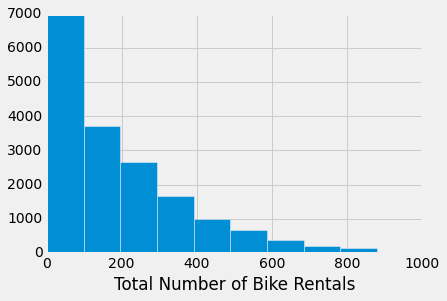

In [125]:
plt.hist(bike_rentals['cnt'])
plt.xlabel('Total Number of Bike Rentals')
plt.show()

In [126]:
bike_corr = bike_rentals.corr()['cnt'].abs().sort_values()
bike_corr

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

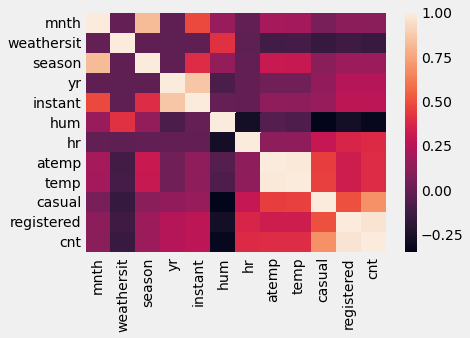

In [130]:
strong_corr = bike_corr[bike_corr > .1]
sns.heatmap(bike_rentals[strong_corr.index].corr())

The columns `casual` and `registered` are added to give the value for `cnt` which will be used for out target.  We will drop these columns later on before we train the data.  <br>
Below we create a function to assign order to the hour column using the labels:
* `morning`  : 1 if the hour is from `6`  to `12`
* `afternoon`: 2 if the hour is from `12` to `18`
* `evening`  : 3 if the hour is from `8`  to `24`
* `night`    : 4 if the hour is from `0`  to `6`

In [203]:
def assign_label(hour):
    if (hour >= 6) and (hour <12):
        return 1
    elif (hour >= 12) and (hour <18):
        return 2
    elif (hour >= 18) and (hour <=24):
        return 3
    else:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(lambda row: assign_label(row))
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


We need to split the data set into train and test. We will start with selecting 80% of `bike_rentals` for `train` and the remainder for `test`.  We will use the Mean Squared Error(MSE) for the error metric since is work well with our data in the target column, `cnt`, which is continuous, numeric data.

In [204]:
train = bike_rentals.sample(frac=.8,random_state = 1)

In [205]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [206]:
train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'time_label'],
      dtype='object')

In [207]:
strong_corr.index

Index(['mnth', 'weathersit', 'season', 'yr', 'instant', 'hum', 'hr', 'atemp',
       'temp', 'casual', 'registered', 'cnt'],
      dtype='object')

In [208]:
col_to_drop=['instant','dteday','casual','registered','cnt']
#drop columns for both train and test datasets, create a target for each
train_target=train['cnt']
train_features=train.drop(col_to_drop, axis=1)

test_target=test['cnt']
test_features=test.drop(col_to_drop, axis=1)

#### Linear Regression

In [209]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train_features, train_target)
predictions_lr = lr.predict(test_features)
mse_lr = mean_squared_error(test_target, predictions_lr)

print('MSE:', round(mse_lr,2))

MSE: 17054.96


In [210]:
bike_rentals.cnt.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

The error is pretty large.  This is likely due to the large range of values for `cnt`.  Above you can see the minimum value is 1 and the maximum value is 977.  Most of the number of bike rentals are low but there are a few very high values.  MSE penalizes larger errors more.<br>

#### Decision Tree Regressor

In [211]:
from sklearn.tree import DecisionTreeRegressor

#default parameters
dt = DecisionTreeRegressor()
dt.fit(train_features, train_target)
predictions_dt = dt.predict(test_features)
mse_dt = mean_squared_error(test_target, predictions_dt)

print('MSE:', round(mse_dt,2))


MSE: 3398.99


In [212]:
dt

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [213]:
#varying parameters for Decision Tree

#min_samples_leaf
min_sx_leaf=[2,3,4,5,6,10]
mse={}
for i in min_sx_leaf:
    dt = DecisionTreeRegressor(min_samples_leaf=i)
    dt.fit(train_features, train_target)
    predictions_dt = dt.predict(test_features)
    mse_dt = mean_squared_error(test_target, predictions_dt)
    mse[i]=round(mse_dt,2)
    
print(mse)

{2: 3110.02, 3: 3123.9, 4: 3043.47, 5: 3030.98, 6: 2935.27, 10: 2952.1}


Above we varied the number of leaves from 2 to 10. Adding more leaves does improve the error.  Decision Trees can pick up nonlinear interactions that Linear Regression cannot so it can perform better (higher accuracy) in these cases where there is both linear and nonlinear data.<br>
#### Random Forest Regressor

In [214]:
from sklearn.ensemble import RandomForestRegressor

#default parameters
rf = RandomForestRegressor()
rf.fit(train_features, train_target)
predictions_rf = rf.predict(test_features)
mse_rf = mean_squared_error(test_target, predictions_rf)

print('MSE:', round(mse_rf,2))


MSE: 1950.58


In [215]:
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [216]:
#varying parameters for Random Forest

#min_samples_leaf
min_sx_leaf=[2,3,4,5,6,10]
mse={}
for i in min_sx_leaf:
    rf = RandomForestRegressor(min_samples_leaf=i)
    rf.fit(train_features, train_target)
    predictions_rf = rf.predict(test_features)
    mse_rf = mean_squared_error(test_target, predictions_rf)

    mse[i]=round(mse_rf,2)
    
print(mse)

{2: 1938.3, 3: 1990.83, 4: 2071.06, 5: 2133.39, 6: 2202.53, 10: 2480.97}


The error improved for the Random Forest Regressor when we increased the min_samples_leaf value from 1 to 2, however it did not improve as we continued to add leaves.  
Random Forest performed the best out of the three methods.

In [217]:
#increase n_estimators to 200
rf = RandomForestRegressor(n_estimators=200,min_samples_leaf=2)
rf.fit(train_features, train_target)
predictions_rf = rf.predict(test_features)
mse_rf = mean_squared_error(test_target, predictions_rf)

print('MSE:', round(mse_rf,2))

MSE: 1914.76


Increasing the number of estimators to 200 did improve the accuracy of the model.  

In [218]:
bike_rentals.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,2.492548
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,1.115284
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,1.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,2.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,3.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,4.000000


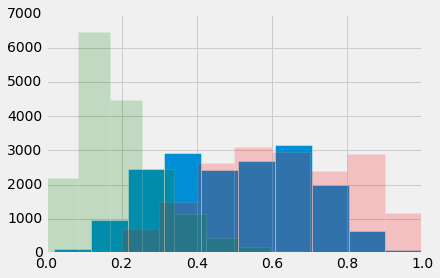

In [227]:
plt.hist(bike_rentals['temp'])
plt.hist(bike_rentals['hum'], color='r',alpha=0.2)
plt.hist(bike_rentals['windspeed'], color='g',alpha=0.2)
plt.show()

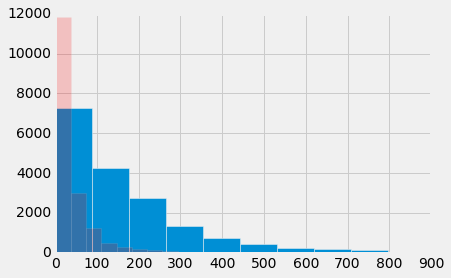

In [228]:
plt.hist(bike_rentals['registered'])
plt.hist(bike_rentals['casual'], color='r', alpha=0.2)
plt.show()

Below we will compare the error values for Random Forest Resgression with target as `cnt`, `registered`, and `casual` for out best model above.  We will use `min_samples_leaf` = 2 and `n_estimators` = 200.

In [231]:
col_to_drop=['instant','dteday','casual','registered','cnt']

#drop columns for both train and test datasets,
train_features=train.drop(col_to_drop, axis=1)
test_features=test.drop(col_to_drop, axis=1)

#target columns to test
target_cols = ['casual','registered','cnt']

for t in target_cols:
    rf = RandomForestRegressor(n_estimators=200,min_samples_leaf=2)
    rf.fit(train_features, train[t])
    predictions_rf = rf.predict(test_features)
    mse_rf = round(mean_squared_error(test[t], predictions_rf),2)

    print('MSE:', t, mse_rf)

MSE: casual 219.68
MSE: registered 1352.03
MSE: cnt 1932.55


The model is most accurate when using the casual rentals as the target column for predictions. If you look at the max value of the casual rentals it is 367 and the registered max is 886 rentals.  That is about 40% less rentals than teh registered which could likely attribute to a smaller error. 